# <center>TabularPlaygroundRegressor Feb2021</center>
<img src= "https://assets.thesmartcube.com/smartcube/app/uploads/2020/10/shutterstock_image-12.jpg" height="200" align="center"/>

<a id="Table-Of-Contents"></a>
# Table Of Contents
* [Table Of Contents](#Table-Of-Contents)
* [Introduction](#Introduction)
* [Importing Libraries](#Importing-Libraries)
* [Task Details](#Task-Details)
* [Read in Data](#Read-in-Data)
    - [Train.csv](#Train.csv)
    - [Test.csv](#Test.csv)
    - [Notes](#Notes)
* [Data Visualization](#Data-Visualization)
    - [Categorical Features](#Categorical-Features)
    - [Continuous Features](#Continuous-Features)
    - [Target](#Target)
* [Preprocessing Data](#Preprocessing-Data)
    - [Label Encoding](#Label-Encoding)
    - [Train-Test Split](#Train-Test-Split)
* [Initial Models](#Initial-Models)
* [Random Firest  Regressor](#Random-Forest-Regressor)
    - [RF Cross Validation](#RF-Cross-Validation)
* [LightGBM Regressor](#LightGBM-Regressor)
    - [Bayesian Optimization](#Bayesian-Optimization)
    - [Tuning LightGBM](#Tuning-LightGBM)
* [Prediction for Test Data](#Prediction-for-Test-Data)
* [Conclusion](#Conclusion)

<a id="Introduction"></a>
# Introduction
This is my second competition notebook on Kaggle. I hope to learn more about working with tabular data and I hope anyone who reads this learns more as well! I will be using various machine learning techniques such as LightGBM, Random Forest, Support Vector Machine, and XGBoost. If you have any questions or comments please leave below! As always leave a upvote as well!  

<a id="Importing-Libraries"></a>
# Importing Libraries

In [1]:
#%% Imports

# Basic Imports 
import numpy as np
import pandas as pd

# Plotting 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

# Preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

# Metrics 
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ML Models
import lightgbm as lgb
from lightgbm import LGBMRegressor 
import xgboost as xg 
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm

# Model Tuning 
from bayes_opt import BayesianOptimization

# Feature Importance 
import shap

# Ignore Warnings 
import warnings
warnings.filterwarnings('ignore')

<a id="Task-Details"></a>
# Task Detail 

## Goal
For this competition, you will be predicting a continuous **target** based on a number of feature columns given in the data. All of the feature columns, **cat0** - **cat9** are **categorical**, and the feature columns **cont0** - **cont13** are **continuous**.

## Metric
Submissions are scored on the root mean squared error. RMSE is defined as:
$$\text{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

where  is the predicted value,  is the original value, and  is the number of rows in the test data.

<a id="Read-in-Data"></a>
# Read in Data

<a id="Train.csv"></a>
## Train.csv

In [2]:
#%% Read train.csv
train_csv = pd.read_csv('../input/tabular-playground-series-feb-2021/train.csv')

# Initial glance at train.csv
print(train_csv.info(verbose = True,show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 26 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      300000 non-null  int64  
 1   cat0    300000 non-null  object 
 2   cat1    300000 non-null  object 
 3   cat2    300000 non-null  object 
 4   cat3    300000 non-null  object 
 5   cat4    300000 non-null  object 
 6   cat5    300000 non-null  object 
 7   cat6    300000 non-null  object 
 8   cat7    300000 non-null  object 
 9   cat8    300000 non-null  object 
 10  cat9    300000 non-null  object 
 11  cont0   300000 non-null  float64
 12  cont1   300000 non-null  float64
 13  cont2   300000 non-null  float64
 14  cont3   300000 non-null  float64
 15  cont4   300000 non-null  float64
 16  cont5   300000 non-null  float64
 17  cont6   300000 non-null  float64
 18  cont7   300000 non-null  float64
 19  cont8   300000 non-null  float64
 20  cont9   300000 non-null  float64
 21  cont10  30

<a id="Test.csv"></a>
## Test.csv

In [3]:
#%% Read train.csv
test_csv = pd.read_csv('../input/tabular-playground-series-feb-2021/test.csv')

# Initial glance at train.csv
print(test_csv.info(verbose = True,show_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      200000 non-null  int64  
 1   cat0    200000 non-null  object 
 2   cat1    200000 non-null  object 
 3   cat2    200000 non-null  object 
 4   cat3    200000 non-null  object 
 5   cat4    200000 non-null  object 
 6   cat5    200000 non-null  object 
 7   cat6    200000 non-null  object 
 8   cat7    200000 non-null  object 
 9   cat8    200000 non-null  object 
 10  cat9    200000 non-null  object 
 11  cont0   200000 non-null  float64
 12  cont1   200000 non-null  float64
 13  cont2   200000 non-null  float64
 14  cont3   200000 non-null  float64
 15  cont4   200000 non-null  float64
 16  cont5   200000 non-null  float64
 17  cont6   200000 non-null  float64
 18  cont7   200000 non-null  float64
 19  cont8   200000 non-null  float64
 20  cont9   200000 non-null  float64
 21  cont10  20

<a id="Notes"></a>
## Notes

Train.csv and Test.csv have no missing values so imputation is not needed. Since there aren't many features in this dataset I can do a quick explanatory data analysis on the features and target.

<a id="Data-Visualization"></a>
# Data Visualization 

<a id="Categorical-Features"></a>
## Categorical Features

In [4]:
#%% PlotMultiplePie 
# Input: df = Pandas dataframe, categorical_features = list of features , dropna = boolean variable to use NaN or not
# Output: prints multiple px.pie() 

def PlotMultiplePie(df,categorical_features = None,dropna = False):
    # set a threshold of 30 unique variables, more than 50 can lead to ugly pie charts 
    threshold = 30
    
    # if user did not set categorical_features 
    if categorical_features == None: 
        categorical_features = df.select_dtypes(['object','category']).columns.to_list()
        
    print("The Categorical Features are:",categorical_features)
    
    # loop through the list of categorical_features 
    for cat_feature in categorical_features: 
        num_unique = df[cat_feature].nunique(dropna = dropna)
        num_missing = df[cat_feature].isna().sum()
        # prints pie chart and info if unique values below threshold 
        if num_unique <= threshold:
            print('Pie Chart for: ', cat_feature)
            print('Number of Unique Values: ', num_unique)
            print('Number of Missing Values: ', num_missing)
            fig = px.pie(df[cat_feature].value_counts(dropna = dropna), values=cat_feature, 
                 names = df[cat_feature].value_counts(dropna = dropna).index,title = cat_feature,template='ggplot2')
            fig.show()
        else: 
            print('Pie Chart for ',cat_feature,' is unavailable due high number of Unique Values ')
            print('Number of Unique Values: ', num_unique)
            print('Number of Missing Values: ', num_missing)
            print('\n')

In [5]:
#%% Use PlotMultiplePie to see the distribution of the categorical variables 
PlotMultiplePie(train_csv.drop("id",axis = "columns"))

The Categorical Features are: ['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8', 'cat9']
Pie Chart for:  cat0
Number of Unique Values:  2
Number of Missing Values:  0


Pie Chart for:  cat1
Number of Unique Values:  2
Number of Missing Values:  0


Pie Chart for:  cat2
Number of Unique Values:  2
Number of Missing Values:  0


Pie Chart for:  cat3
Number of Unique Values:  4
Number of Missing Values:  0


Pie Chart for:  cat4
Number of Unique Values:  4
Number of Missing Values:  0


Pie Chart for:  cat5
Number of Unique Values:  4
Number of Missing Values:  0


Pie Chart for:  cat6
Number of Unique Values:  8
Number of Missing Values:  0


Pie Chart for:  cat7
Number of Unique Values:  8
Number of Missing Values:  0


Pie Chart for:  cat8
Number of Unique Values:  7
Number of Missing Values:  0


Pie Chart for:  cat9
Number of Unique Values:  15
Number of Missing Values:  0


<a id="Continuous-Features"></a>
## Continuous Features

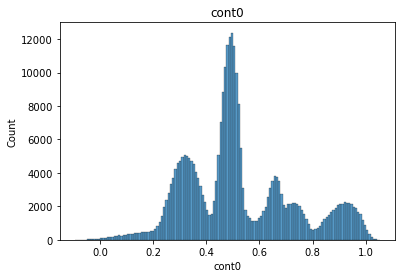

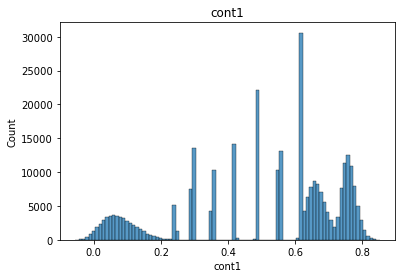

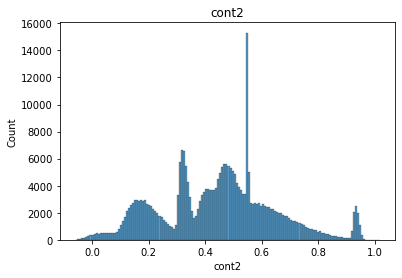

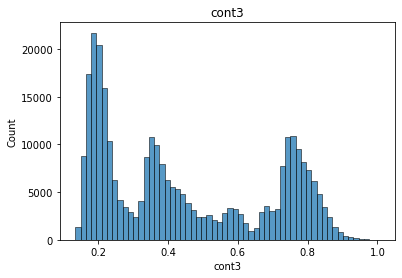

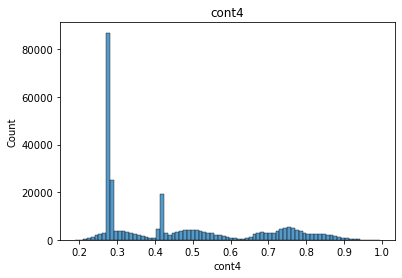

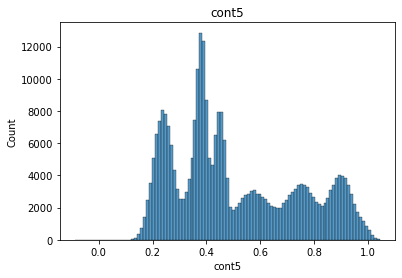

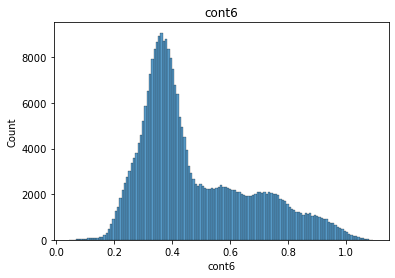

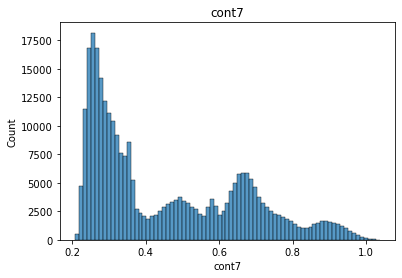

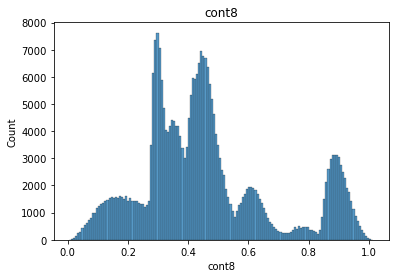

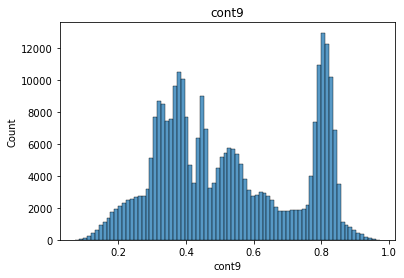

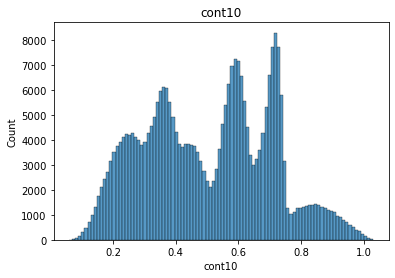

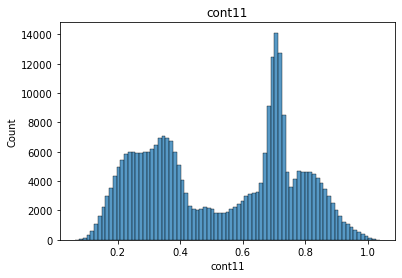

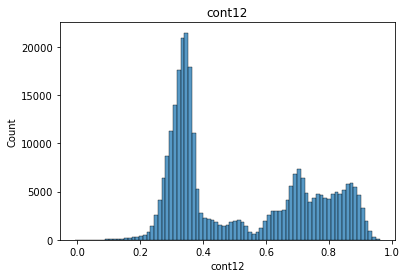

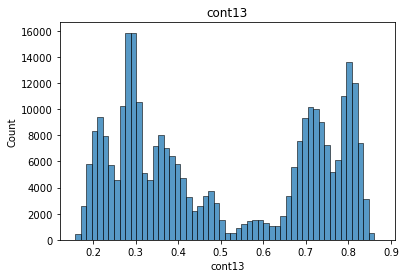

In [6]:
#%% Print the continous features in the dataset 
continous_features = train_csv.drop(["id","target"],axis = "columns").select_dtypes(['float64']).columns.to_list()

for cont_feature in continous_features: 
    plt.figure()
    plt.title(cont_feature)
    ax = sns.histplot(train_csv[cont_feature])

<a id="Target"></a>
## Target

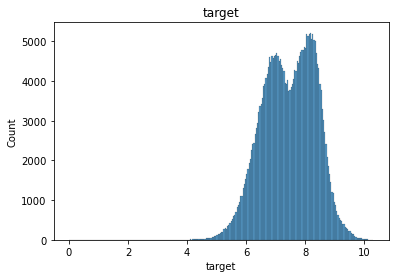

In [7]:
plt.figure()
plt.title("target")
ax = sns.histplot(train_csv["target"])

<a id="Preprocessing-Data"></a>
# Preprocessing Data
Because Train.csv and Test.csv have no missing data imputation is not needed.  
Label encoding is still require as this dataset has categorical features 

In [8]:
# save the 'id' for Train and Test 
train_csv_id = train_csv['id'].to_list()
test_csv_id = test_csv['id'].to_list()

# Seperate train_clean into target and features 
y = train_csv['target']
X_train_clean = train_csv.drop('target',axis = 'columns')

# Save the index for X_train_clean 
X_train_clean_index = X_train_clean.index.to_list()

# Row bind train.csv features with test.csv features 
# this makes it easier to apply label encoding onto the entire dataset 
X_total = X_train_clean.append(test_csv,ignore_index = True)

# save the index for test.csv 
X_test_clean_index = np.setdiff1d(X_total.index.to_list() ,X_train_clean_index) 

# drop id from X_total
X_total = X_total.drop('id',axis = 'columns')

X_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 24 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    500000 non-null  object 
 1   cat1    500000 non-null  object 
 2   cat2    500000 non-null  object 
 3   cat3    500000 non-null  object 
 4   cat4    500000 non-null  object 
 5   cat5    500000 non-null  object 
 6   cat6    500000 non-null  object 
 7   cat7    500000 non-null  object 
 8   cat8    500000 non-null  object 
 9   cat9    500000 non-null  object 
 10  cont0   500000 non-null  float64
 11  cont1   500000 non-null  float64
 12  cont2   500000 non-null  float64
 13  cont3   500000 non-null  float64
 14  cont4   500000 non-null  float64
 15  cont5   500000 non-null  float64
 16  cont6   500000 non-null  float64
 17  cont7   500000 non-null  float64
 18  cont8   500000 non-null  float64
 19  cont9   500000 non-null  float64
 20  cont10  500000 non-null  float64
 21  cont11  50

<a id="Label-Encoding.csv"></a>
## Label Encoding

In [9]:
#%% MultiColumnLabelEncoder
# Code snipet found on Stack Exchange 
# https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
# from sklearn.preprocessing import LabelEncoder

class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                # convert float NaN --> string NaN
                output[col] = output[col].fillna('NaN')
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

# store the catagorical features names as a list      
cat_features = X_total.select_dtypes(['object']).columns.to_list()

# use MultiColumnLabelEncoder to apply LabelEncoding on cat_features 
# uses NaN as a value , no imputation will be used for missing data
X_total_encoded = MultiColumnLabelEncoder(columns = cat_features).fit_transform(X_total)

In [10]:
##% Split X_total_encoded 
X_train_clean_encoded = X_total_encoded.iloc[X_train_clean_index, :]
X_test_clean_encoded = X_total_encoded.iloc[X_test_clean_index, :].reset_index(drop = True) 
X_train_clean_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 0 to 299999
Data columns (total 24 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    300000 non-null  int64  
 1   cat1    300000 non-null  int64  
 2   cat2    300000 non-null  int64  
 3   cat3    300000 non-null  int64  
 4   cat4    300000 non-null  int64  
 5   cat5    300000 non-null  int64  
 6   cat6    300000 non-null  int64  
 7   cat7    300000 non-null  int64  
 8   cat8    300000 non-null  int64  
 9   cat9    300000 non-null  int64  
 10  cont0   300000 non-null  float64
 11  cont1   300000 non-null  float64
 12  cont2   300000 non-null  float64
 13  cont3   300000 non-null  float64
 14  cont4   300000 non-null  float64
 15  cont5   300000 non-null  float64
 16  cont6   300000 non-null  float64
 17  cont7   300000 non-null  float64
 18  cont8   300000 non-null  float64
 19  cont9   300000 non-null  float64
 20  cont10  300000 non-null  float64
 21  cont11  30

In [11]:
##% Before and After LabelEncoding for train.csv 
display(X_train_clean.head().drop("id",axis = 'columns'))
display(X_train_clean_encoded.head())

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,A,B,A,A,B,D,A,E,C,I,...,0.281421,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903
1,B,A,A,A,B,B,A,E,A,F,...,0.282354,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464
2,A,A,A,C,B,D,A,B,C,N,...,0.293756,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352
3,A,A,A,C,B,D,A,E,G,K,...,0.769785,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766
4,A,B,A,A,B,B,A,E,C,F,...,0.279105,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743


,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0,1,0,0,1,3,0,4,2,8,...,0.281421,0.881122,0.421650,0.741413,0.895799,0.802461,0.724417,0.701915,0.877618,0.719903
1,1,0,0,0,1,1,0,4,0,5,...,0.282354,0.440011,0.346230,0.278495,0.593413,0.546056,0.613252,0.741289,0.326679,0.808464
2,0,0,0,2,1,3,0,1,2,13,...,0.293756,0.914155,0.369602,0.832564,0.865620,0.825251,0.264104,0.695561,0.869133,0.828352
3,0,0,0,2,1,3,0,4,6,10,...,0.769785,0.934138,0.578930,0.407313,0.868099,0.794402,0.494269,0.698125,0.809799,0.614766
4,0,1,0,0,1,1,0,4,2,5,...,0.279105,0.382600,0.705940,0.325193,0.440967,0.462146,0.724447,0.683073,0.343457,0.297743


In [12]:
##% Before and After LabelEncoding for test.csv 
display(test_csv.head().drop("id",axis = 'columns'))
display(X_test_clean_encoded.head())

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,A,B,A,C,B,D,A,E,E,G,...,0.701679,0.595507,0.286912,0.279884,0.202234,0.242654,0.285147,0.264308,0.653654,0.302448
1,A,B,A,C,B,D,A,E,C,L,...,0.277480,0.479552,0.397436,0.476742,0.857073,0.516393,0.562065,0.730542,0.318492,0.736251
2,A,B,A,C,B,D,A,E,C,F,...,0.279508,0.676395,0.695284,0.253316,0.586934,0.548555,0.836193,0.759788,0.333572,0.273905
3,A,A,B,A,B,D,A,E,E,F,...,0.479503,0.759875,0.240049,0.298074,0.442475,0.596746,0.414131,0.255382,0.589080,0.311625
4,A,B,A,A,B,B,A,E,E,I,...,0.757845,0.210232,0.329851,0.616663,0.170475,0.263235,0.710961,0.224045,0.285860,0.794931


,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13
0,0,1,0,2,1,3,0,4,4,6,...,0.701679,0.595507,0.286912,0.279884,0.202234,0.242654,0.285147,0.264308,0.653654,0.302448
1,0,1,0,2,1,3,0,4,2,11,...,0.277480,0.479552,0.397436,0.476742,0.857073,0.516393,0.562065,0.730542,0.318492,0.736251
2,0,1,0,2,1,3,0,4,2,5,...,0.279508,0.676395,0.695284,0.253316,0.586934,0.548555,0.836193,0.759788,0.333572,0.273905
3,0,0,1,0,1,3,0,4,4,5,...,0.479503,0.759875,0.240049,0.298074,0.442475,0.596746,0.414131,0.255382,0.589080,0.311625
4,0,1,0,0,1,1,0,4,4,8,...,0.757845,0.210232,0.329851,0.616663,0.170475,0.263235,0.710961,0.224045,0.285860,0.794931


<a id="#Train-Test-Split"></a>
# Train-Test Split

In [13]:
# Create test and train set 80-20
#%%  train-test stratified split using a 80-20 split
train_X, valid_X, train_y, valid_y = train_test_split(X_train_clean_encoded, y, shuffle = True, test_size=0.2, random_state=0)

train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240000 entries, 154452 to 117952
Data columns (total 24 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    240000 non-null  int64  
 1   cat1    240000 non-null  int64  
 2   cat2    240000 non-null  int64  
 3   cat3    240000 non-null  int64  
 4   cat4    240000 non-null  int64  
 5   cat5    240000 non-null  int64  
 6   cat6    240000 non-null  int64  
 7   cat7    240000 non-null  int64  
 8   cat8    240000 non-null  int64  
 9   cat9    240000 non-null  int64  
 10  cont0   240000 non-null  float64
 11  cont1   240000 non-null  float64
 12  cont2   240000 non-null  float64
 13  cont3   240000 non-null  float64
 14  cont4   240000 non-null  float64
 15  cont5   240000 non-null  float64
 16  cont6   240000 non-null  float64
 17  cont7   240000 non-null  float64
 18  cont8   240000 non-null  float64
 19  cont9   240000 non-null  float64
 20  cont10  240000 non-null  float64
 21  cont1

<a id="Initial Models"></a>
# Initial Models
I applied different machine learning algorthims to test which model perform better on this dataset. I've listed below various machine learning techniques applied in this section.
 
1. RandomForest
2. LightGBM

In [14]:
##% evaluateRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error
def evaluateRegressor(true,predicted,message):
    MSE = mean_squared_error(true,predicted,squared = True)
    MAE = mean_absolute_error(true,predicted)
    RMSE = mean_squared_error(true,predicted,squared = False)
    print(message)
    print("MSE:", MSE)
    print("MAE:", MAE)
    print("RMSE:", RMSE)

In [15]:
def PlotPrediction(true,predicted, title = "Dataset: "):
    fig = plt.figure(figsize=(20,20))
    ax1 = fig.add_subplot(111)
    ax1.set_title(title + 'True vs Predicted')
    ax1.scatter(list(range(0,len(true))),true, s=10, c='r', marker="o", label='True')
    ax1.scatter(list(range(0,len(predicted))), predicted, s=10, c='b', marker="o", label='Predicted')
    plt.legend(loc='upper right');
    plt.show()

In [16]:
#% Initial Models
# from sklearn.ensemble import RandomForestRegressor
# import lightgbm as lgb

RFReg = RandomForestRegressor(n_estimators = 10, criterion = "mse", max_depth = 10, n_jobs = -1,random_state = 0).fit(train_X, train_y)
LGBMReg = lgb.LGBMRegressor(max_depth = 10,random_state=0).fit(train_X,train_y)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [17]:
# % Model Metrics

print("Random Forest Regressor") 
predicted_train_y = RFReg.predict(train_X)
evaluateRegressor(train_y,predicted_train_y,"    Training Set")
predicted_valid_y = RFReg.predict(valid_X)
evaluateRegressor(valid_y,predicted_valid_y,"    Test Set")
print("\n")

print("LightGBM Regressor") 
predicted_train_y = LGBMReg.predict(train_X)
evaluateRegressor(train_y,predicted_train_y,"    Training Set")
predicted_valid_y = LGBMReg.predict(valid_X)
evaluateRegressor(valid_y,predicted_valid_y,"    Test Set")

Random Forest Regressor
    Training Set
MSE: 0.7112874016072529
MAE: 0.7050083032876819
RMSE: 0.8433785636398716
    Test Set
MSE: 0.7418161460707243
MAE: 0.7205336985945567
RMSE: 0.8612874932742982


LightGBM Regressor
    Training Set
MSE: 0.7009912921702588
MAE: 0.7000576703438333
RMSE: 0.8372522273307242
    Test Set
MSE: 0.7170291009121491
MAE: 0.708502573887076
RMSE: 0.8467757087400117


<a id="Random-Forest-Regressor"></a>
# Random Forest Regressor
The model can be improved by using cross validation. I used 5-fold cross validation. 

<a id="RF-Cross-Validation"></a>
## RF Cross Validation

In [18]:
# Cross validation using Random Forest
from sklearn.model_selection import KFold

param_rf = {'n_estimators': 20, 
            'criterion': 'mse', 
            'max_depth':100,
            'n_jobs' : -1,
            'random_state' : 0}

def K_Fold_RandomForest(X_train,y_train, params_set, num_folds = 5):
    models = []
    folds = KFold(n_splits=num_folds, shuffle=True, random_state=0)

    y_preds = np.zeros_like(y_train, dtype=np.float64)
    feature_importance_df = pd.DataFrame()

        # 5 times 
    for n_fold, (train_idx, valid_idx) in enumerate (folds.split(X_train, y_train)):
        train_X, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_X, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]

        CV_RF = RandomForestRegressor(**params_set).fit(train_X, train_y)
        models.append(CV_RF)
        
    for num in range(0,len(models)): 
        print(f"     model {num}")
        print("Train set RMSE:", mean_squared_error(train_y,models[num].predict(train_X),squared = False))
        print(" Test set RMSE:", mean_squared_error(valid_y,models[num].predict(valid_X),squared = False))
        print("\n")
    return models

rf_models = K_Fold_RandomForest(X_train_clean_encoded,y,param_rf,5)

     model 0
Train set RMSE: 0.5322253460533578
 Test set RMSE: 0.3490198653058927


     model 1
Train set RMSE: 0.5321281022124836
 Test set RMSE: 0.35009718884774416


     model 2
Train set RMSE: 0.5331739150295707
 Test set RMSE: 0.3497935079077444


     model 3
Train set RMSE: 0.5316093541779089
 Test set RMSE: 0.3503232001703691


     model 4
Train set RMSE: 0.3484481934738849
 Test set RMSE: 0.878362842188693




Train.csv
MSE: 0.1832798945477322
MAE: 0.3555804728760871
RMSE: 0.4281120116835455


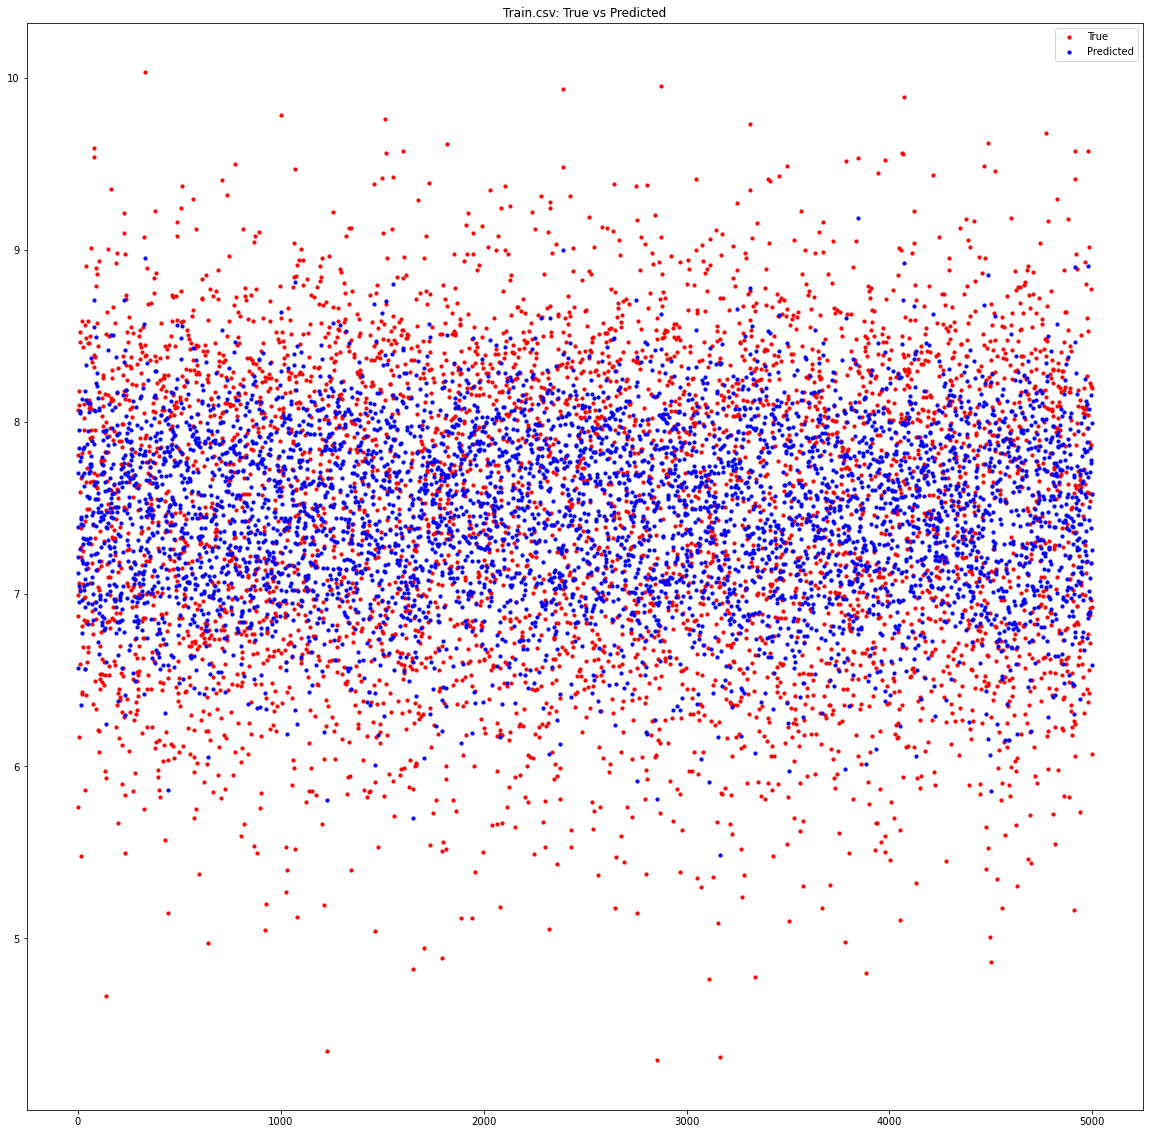

In [19]:
# Predict y_prds using models from crossvalidation 
def predict_cv(models_cv,X):
    y_preds = np.zeros(shape = X.shape[0])
    for model in models_cv:
        y_preds += model.predict(X)
        
    return y_preds/len(models_cv)
predicted_y = predict_cv(rf_models,X_train_clean_encoded)
# evalute model using the entire dataset from Train.csv
evaluateRegressor(y,predicted_y,"Train.csv")
PlotPrediction(y[0:5000],predicted_y[0:5000], title = "Train.csv: ")

<a id="LightGBM-Regressor"></a>
# LightGBM Regressor
the LightGBM model can be imporved by applying cross validation as well. I also used parameter tuning to obtain a better model. 

<a id="Bayesian-Optimization"></a>
## Bayesian Optimization

In [20]:
##% Parameter Tuning for LightGBM
# store the catagorical features names as a list      
cat_features = X_train_clean_encoded.select_dtypes(['object']).columns.to_list()

# https://medium.com/analytics-vidhya/hyperparameters-optimization-for-lightgbm-catboost-and-xgboost-regressors-using-bayesian-6e7c495947a9
# from lightgbm import LGBMRegressor 
# from bayes_opt import BayesianOptimization
def search_best_param(X,y,cat_features):
    
    trainXY = lgb.Dataset(data=X, label=y,categorical_feature = cat_features,free_raw_data=False)
    # define the lightGBM cross validation
    def lightGBM_CV(max_depth, num_leaves, n_estimators, learning_rate, subsample, colsample_bytree, 
                lambda_l1, lambda_l2, min_child_weight):
    
        params = {'boosting_type': 'gbdt', 'objective': 'regression', 'metric':'rmse', 'verbose': -1,
                  'early_stopping_round':100}
        
        params['max_depth'] = int(round(max_depth))
        params["num_leaves"] = int(round(num_leaves))
        params["n_estimators"] = int(round(n_estimators))
        params['learning_rate'] = learning_rate
        params['subsample'] = subsample
        params['colsample_bytree'] = colsample_bytree
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_child_weight'] = min_child_weight
    
        score = lgb.cv(params, trainXY, nfold=5, seed=1, stratified=False, verbose_eval =False, metrics=['rmse'])

        return -np.min(score['rmse-mean']) # min or max can change best_param

    # use bayesian optimization to search for the best hyper-parameter combination
    # https://github.com/fmfn/BayesianOptimization/blob/master/bayes_opt/bayesian_optimization.pyta
    lightGBM_Bo = BayesianOptimization(lightGBM_CV, 
                                      {
                                          'max_depth': (5, 50),
                                          'num_leaves': (20, 100),
                                          'n_estimators': (50, 1000),
                                          'learning_rate': (0.01, 0.3),
                                          'subsample': (0.7, 0.8),
                                          'colsample_bytree' :(0.5, 0.99),
                                          'lambda_l1': (0, 5),
                                          'lambda_l2': (0, 3),
                                          'min_child_weight': (2, 50) 
                                      },
                                       random_state = 1,
                                       verbose = -1
                                      )
    np.random.seed(1)
    
    lightGBM_Bo.maximize(init_points=5, n_iter=25) # 20 combinations 
    
    params_set = lightGBM_Bo.max['params']
    
    # get the params of the maximum target     
    max_target = -np.inf
    for i in lightGBM_Bo.res: # loop thru all the residuals 
        if i['target'] > max_target:
            params_set = i['params']
            max_target = i['target']
    
    params_set.update({'verbose': -1})
    params_set.update({'metric': 'rmse'})
    params_set.update({'boosting_type': 'gbdt'})
    params_set.update({'objective': 'regression'})
    
    params_set['max_depth'] = int(round(params_set['max_depth']))
    params_set['num_leaves'] = int(round(params_set['num_leaves']))
    params_set['n_estimators'] = int(round(params_set['n_estimators']))
    params_set['seed'] = 1 #set seed
    
    return params_set

best_params = search_best_param(X_train_clean_encoded,y,cat_features)

|   iter    |  target   | colsam... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | n_esti... | num_le... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        | -0.8445   |  0.7043   |  3.602    |  0.000343 |  0.09768  |  11.6     |  6.432    |  226.9    |  47.64    |  0.7397   |
|  2        | -0.8444   |  0.764    |  2.096    |  2.056    |  0.06929  |  44.52    |  3.315    |  686.9    |  53.38    |  0.7559   |
|  3        | -0.848    |  0.5688   |  0.9905   |  2.402    |  0.2908   |  19.1     |  35.23    |  882.6    |  91.57    |  0.7085   |
|  4        | -0.8437   |  0.5191   |  0.8492   |  2.634    |  0.03852  |  23.95    |  47.98    |  556.5    |  75.35    |  0.7316   |
|  5        | -0.8468   |  0.8364   |  4.173    |  0.05486  |  0.2275   |  49.5     |  37.91    |  316.4    |  83.14    |  0.7103   |
|  6        | -0.8452   |  0.9331   |  3.277    |  1.001    | 

In [21]:
#Print best_params
for key, value in best_params.items():
    print(key, ' : ', value)

colsample_bytree  :  0.5191368437841124
lambda_l1  :  0.8491520978228445
lambda_l2  :  2.6344275102882393
learning_rate  :  0.03852058181158453
max_depth  :  24
min_child_weight  :  47.97869744722409
n_estimators  :  557
num_leaves  :  75
subsample  :  0.7315515631006063
verbose  :  -1
metric  :  rmse
boosting_type  :  gbdt
objective  :  regression
seed  :  1


<a id="LightGBM-Cross-Validation"></a>
## LightGBM Cross Validation

In [22]:
def K_Fold_LightGBM(X_train, y_train , cat_features, params_set, num_folds = 5):
    num = 0
    models = []
    folds = KFold(n_splits=num_folds, shuffle=True, random_state=0)

        # 5 times 
    for n_fold, (train_idx, valid_idx) in enumerate (folds.split(X_train, y_train)):
        print(f"     model{num}")
        train_X, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_X, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]
        
        train_data=lgb.Dataset(train_X,label=train_y, categorical_feature = cat_features,free_raw_data=False)
        valid_data=lgb.Dataset(valid_X,label=valid_y, categorical_feature = cat_features,free_raw_data=False)
        
        CV_LGBM = lgb.train(params_set,
                 train_data,
                 num_boost_round = 2500,
                 valid_sets = valid_data,
                 early_stopping_rounds = 100,
                 verbose_eval = 50
                 )
        # increase early_stopping_rounds can lead to overfitting 
        models.append(CV_LGBM)
        
        print("Train set RMSE:", mean_squared_error(train_y,models[num].predict(train_X),squared = False))
        print(" Test set RMSE:", mean_squared_error(valid_y,models[num].predict(valid_X),squared = False))
        print("\n")
        num = num + 1
        
    return models

lgbm_models = K_Fold_LightGBM(X_train_clean_encoded,y,cat_features,best_params,5)

     model0
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 0.857151
[100]	valid_0's rmse: 0.8505
[150]	valid_0's rmse: 0.847782
[200]	valid_0's rmse: 0.846268
[250]	valid_0's rmse: 0.845461
[300]	valid_0's rmse: 0.845063
[350]	valid_0's rmse: 0.844866
[400]	valid_0's rmse: 0.844745
[450]	valid_0's rmse: 0.84479
Early stopping, best iteration is:
[396]	valid_0's rmse: 0.844726
Train set RMSE: 0.8149101722697756
 Test set RMSE: 0.8447257458630961


     model1
Training until validation scores don't improve for 100 rounds
[50]	valid_0's rmse: 0.855562
[100]	valid_0's rmse: 0.848811
[150]	valid_0's rmse: 0.845931
[200]	valid_0's rmse: 0.844341
[250]	valid_0's rmse: 0.843516
[300]	valid_0's rmse: 0.842989
[350]	valid_0's rmse: 0.842694
[400]	valid_0's rmse: 0.84251
[450]	valid_0's rmse: 0.842441
[500]	valid_0's rmse: 0.842354
[550]	valid_0's rmse: 0.84243
Did not meet early stopping. Best iteration is:
[502]	valid_0's rmse: 0.842346
Train set RMSE: 0.8089

Train.csv
MSE: 0.6628889164611591
MAE: 0.6809891590710242
RMSE: 0.8141799042356419


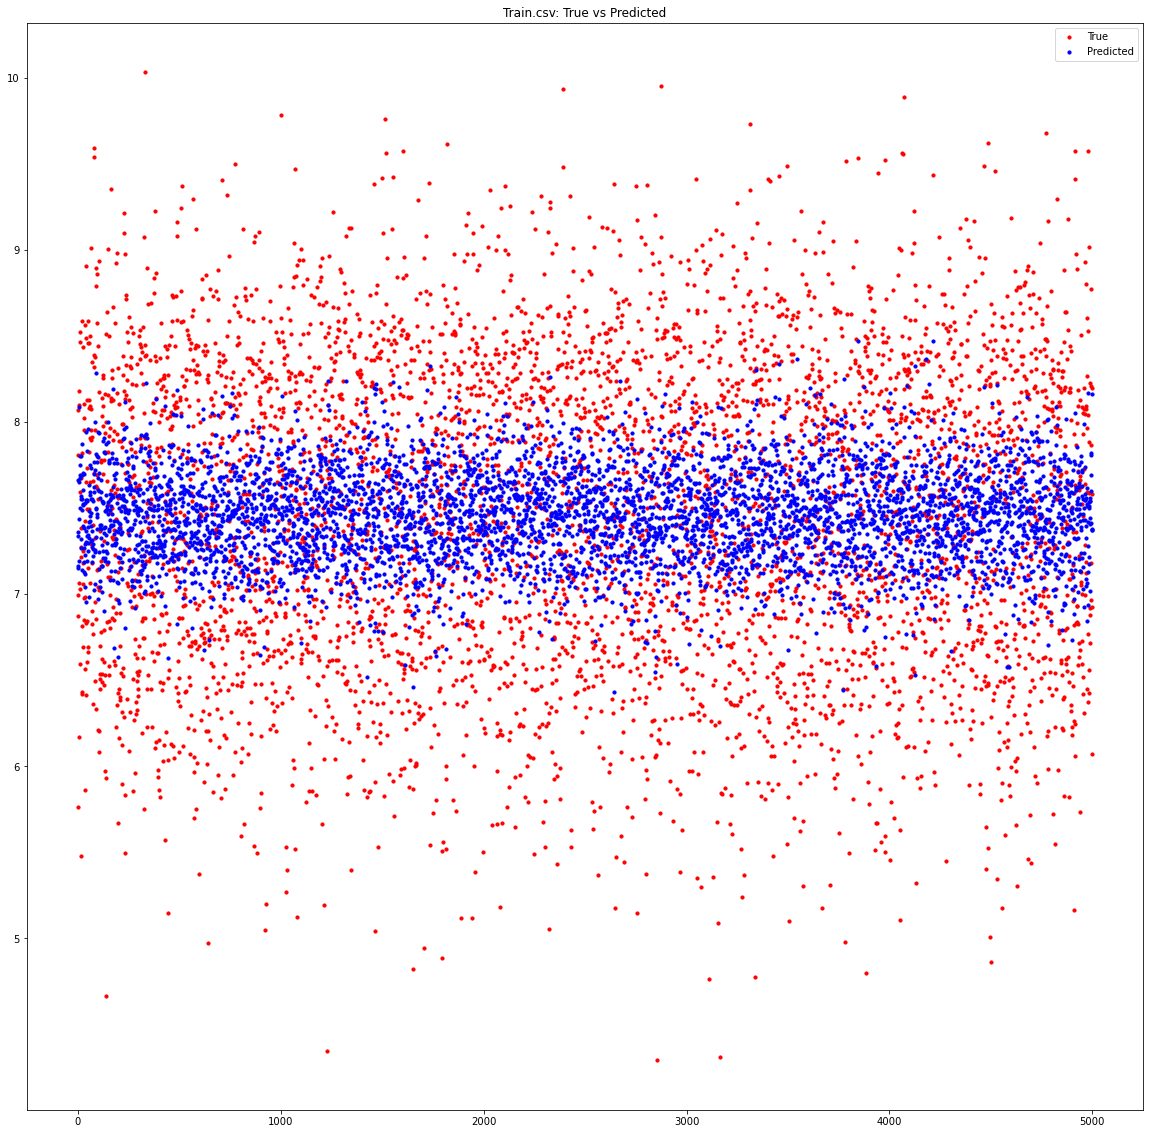

In [23]:
# evalute model using the entire dataset from Train.csv
predicted_y = predict_cv(lgbm_models,X_train_clean_encoded)
evaluateRegressor(y,predicted_y,"Train.csv")
PlotPrediction(y[0:5000],predicted_y[0:5000], title = "Train.csv: ")

<a id="Prediction-for-Test.csv"></a>
# Prediction for Test.csv

In [24]:
# Prediction for Test.csv
predictLGBM = predict_cv(rf_models,X_test_clean_encoded) 
predictRF = predict_cv(lgbm_models,X_test_clean_encoded)

submissionLGBM = pd.DataFrame({'id':test_csv_id,'target':predictLGBM})
submissionRF = pd.DataFrame({'id':test_csv_id,'target':predictRF})

display(submissionLGBM.head())
display(submissionRF.head())

,id,target
0,0,7.290857
1,5,7.800438
2,15,7.482654
3,16,7.398487
4,17,7.611854


,id,target
0,0,7.611948
1,5,7.801855
2,15,7.606436
3,16,7.448008
4,17,7.334680


In [25]:
#% Submit Predictions 
submissionLGBM.to_csv('submissionCV_LGBM4.csv',index=False)
submissionRF.to_csv('submissionCV_RF4.csv',index=False)

<a id="Conclusion"></a>
<a id="Conclusion"></a>
# Conclusion

**Conclusion**
* Cross validation is useful in getting a better model and to lessen overfitting.   

**Challenges**
* The dataset was rather large which led to long computation time.
* Although I used various machine learning algorithims, I wasn't able to improve on score much.    

**Closing Remarks**  
* Please comment and like the notebook if it of use to you! Have a wonderful year! 

**Other Notebooks** 
* [https://www.kaggle.com/josephchan524/hranalytics-lightgbm-classifier-auc-80](https://www.kaggle.com/josephchan524/hranalytics-lightgbm-classifier-auc-80)
* [https://www.kaggle.com/josephchan524/bankchurnersclassifier-recall-97-accuracy-95](https://www.kaggle.com/josephchan524/bankchurnersclassifier-recall-97-accuracy-95)

2-7-2020
Joseph Chan 